
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Well-log data forecasting with uncertainty

### Eduardo Maldonado Cruz, Graduate Research Assistant, The University of Texas at Austin

#### [Twitter](https://twitter.com/emaldonadocruz) | [GitHub](https://github.com/emaldonadocruz) | [LinkedIn](https://www.linkedin.com/in/eduardo-maldonado-8386a898/)

### Michael Pyrcz, Associate Professor, The University of Texas at Austin 

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Library importing

In [1]:
import lasio
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
import pickle
import joblib
import torch
#import lightning.pytorch as pl

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# Get the current working directory
cwd = os.getcwd()
os.chdir(cwd)

Well directory

In [2]:
Las_dir = 'Well_log-las'

file_list = os.listdir(Las_dir)
las_files = glob.glob(Las_dir+'\*.las')

## Well log exploration

In [3]:
las = lasio.read(las_files[7])
#data = las.df().reset_index() # Transform to pandas dataframe, reset index so depth is not the index
data = las.df()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7975 entries, 4530.0 to 8517.0
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NPHI    7975 non-null   float64
 1   ILD     7875 non-null   float64
 2   ILM     7875 non-null   float64
 3   SFL     7875 non-null   float64
 4   SP      7875 non-null   float64
 5   CALI    7865 non-null   float64
 6   DPHI    7875 non-null   float64
 7   DRHO    7871 non-null   float64
 8   GR      7975 non-null   float64
dtypes: float64(9)
memory usage: 623.0 KB


In [5]:
las.curvesdict['DEPT']

CurveItem(mnemonic="DEPT", unit="F", value="00 001 00 00", descr="1  DEPTH", original_mnemonic="DEPT", data.shape=(7975,))

## Plotting

In [6]:
data.columns

Index(['NPHI', 'ILD', 'ILM', 'SFL', 'SP', 'CALI', 'DPHI', 'DRHO', 'GR'], dtype='object')

In [7]:
def plotter(df):
    col = data.columns.unique().shape[0]
    fig, axs = plt.subplots(1,col,figsize=(14,2*col),sharey=True)
    for i in range(col):
        if data.columns[i] == 'ILD' or data.columns[i] == 'SFL' or data.columns[i] == 'ILM':
            axs[i].semilogx(df[df.columns[i]],df.index)
        else:
            axs[i].plot(df[df.columns[i]],df.index)

        axs[i].set_title(f'{df.columns[i]}')
        axs[i].set_xlabel(las.curvesdict[data.columns[i]]['unit'])
        axs[i].set_ylabel('FT')
        axs[i].invert_yaxis()
        axs[i].set_ylim(5000,6000)
    fig.tight_layout()

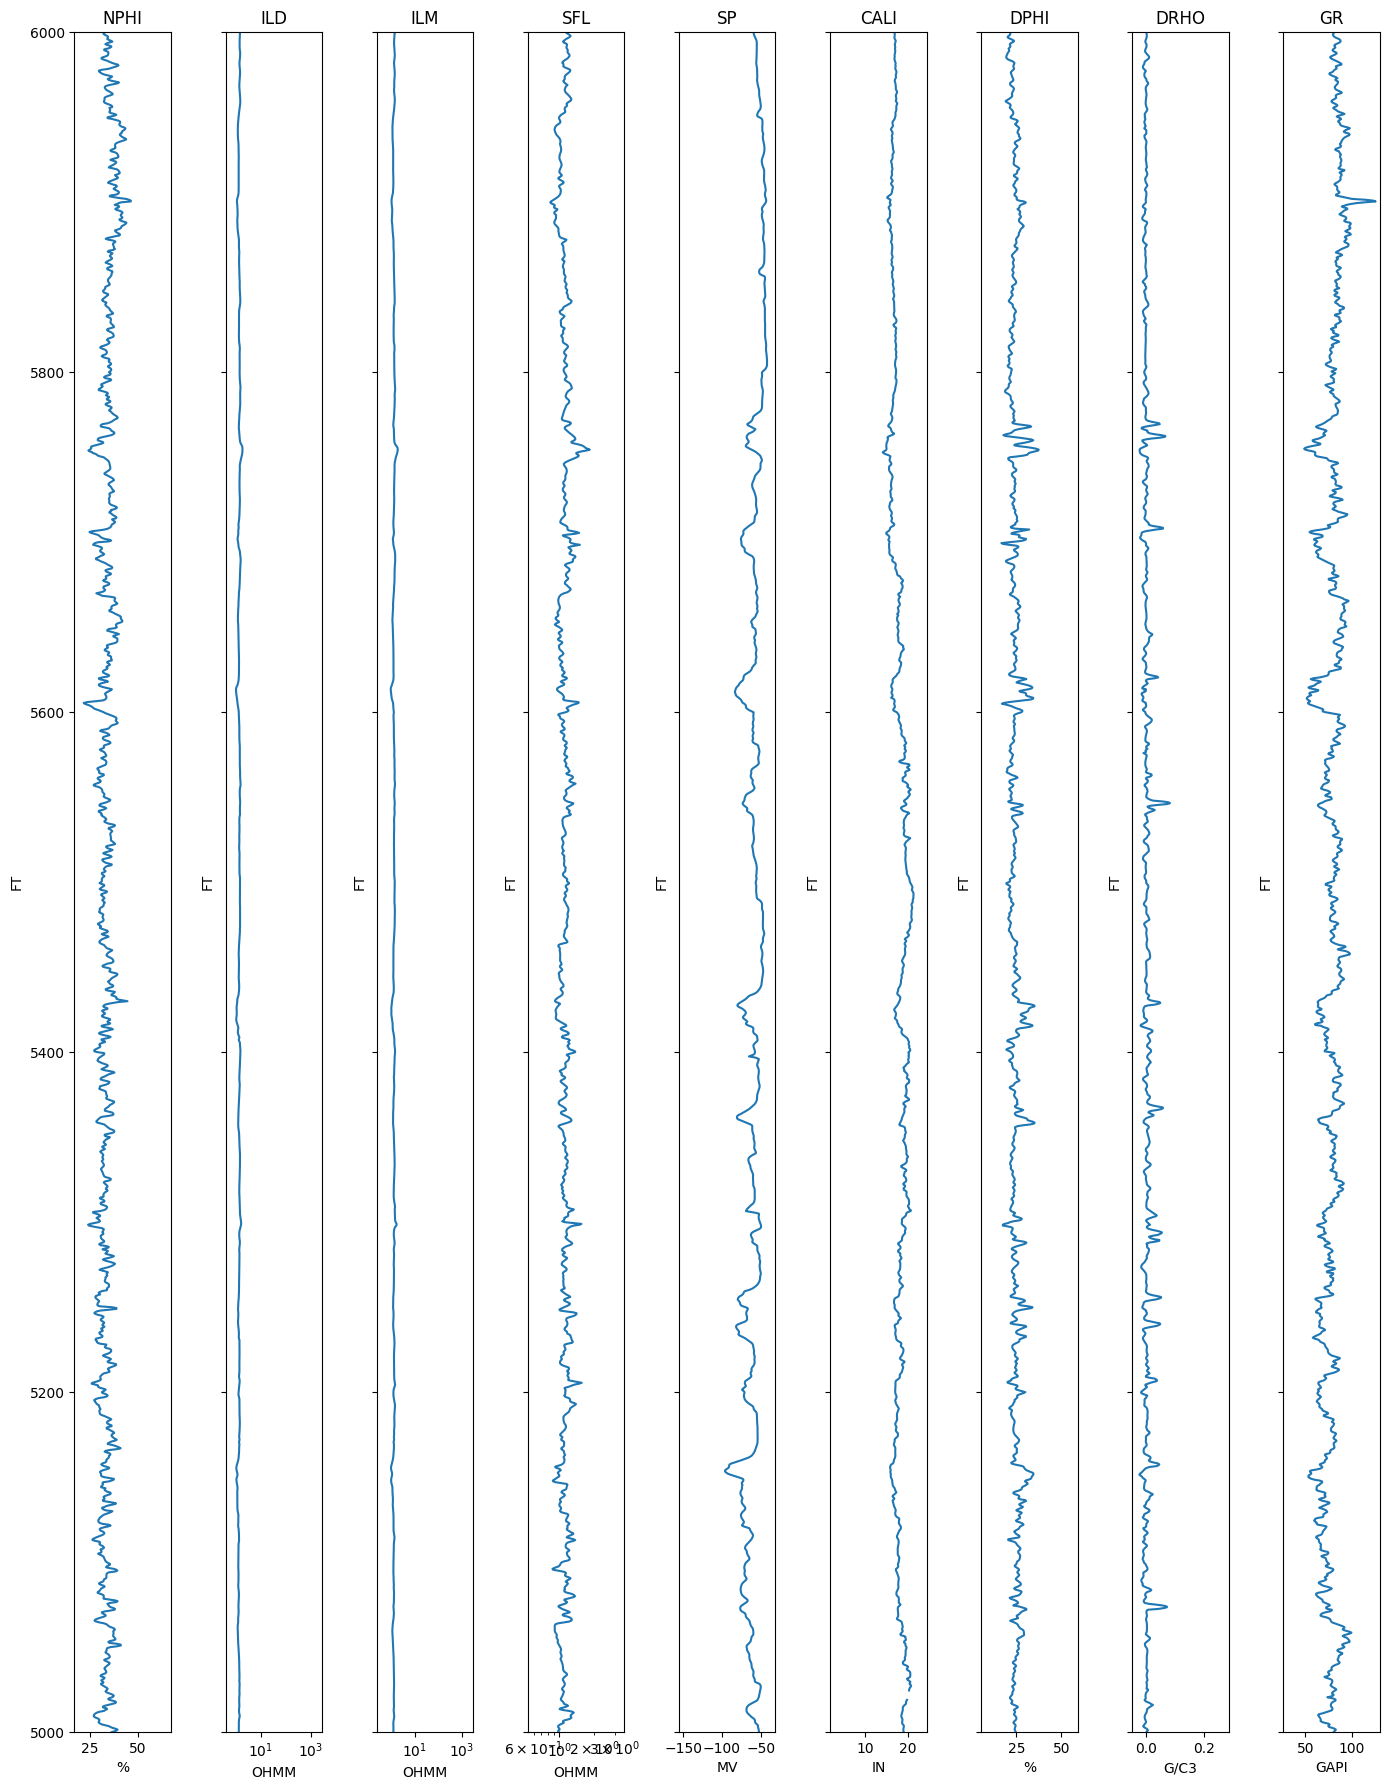

In [8]:
plotter(data)

## Fature Selection based on Mutual Information

We perform feature selection over defined depths using mutual information (Peng et al., 2005; Peng and Fan, 2017) to measure the general pairwise mutual dependence between features and select the conventional well logs (predictor features) with the highest mutual information with the GR well log (response feature). We favor mutual information over correlation analysis for a more flexible measure of information sharing between features, including patterns such as nonlinearity and heteroscedasticity that would negatively impact correlation. 

In [9]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7861 entries, 4582.0 to 8517.0
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NPHI    7861 non-null   float64
 1   ILD     7861 non-null   float64
 2   ILM     7861 non-null   float64
 3   SFL     7861 non-null   float64
 4   SP      7861 non-null   float64
 5   CALI    7861 non-null   float64
 6   DPHI    7861 non-null   float64
 7   DRHO    7861 non-null   float64
 8   GR      7861 non-null   float64
dtypes: float64(9)
memory usage: 614.1 KB


In [10]:
Log_to_predict = 'GR'
#predictors = data.loc[:, data.columns != Log_to_predict]

Feature ranking:
1. feature 6 (1.000000)
2. feature 4 (0.922425)
3. feature 0 (0.814904)
4. feature 2 (0.797967)
5. feature 1 (0.763945)
6. feature 5 (0.669060)
7. feature 3 (0.618342)
8. feature 7 (0.473959)


(-1.0, 8.0)

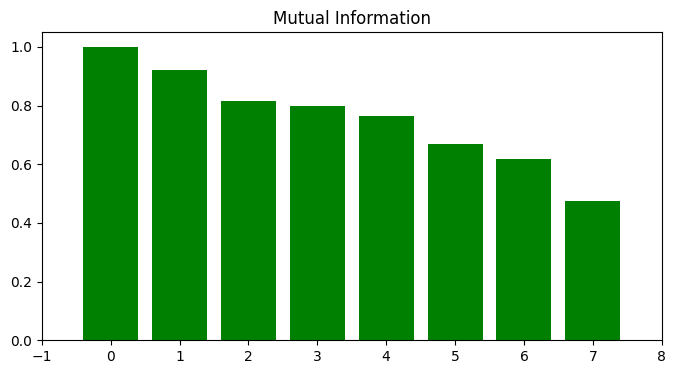

In [11]:
x = data.loc[:,data.columns!=Log_to_predict]
y = data.loc[:,Log_to_predict]

mi = mutual_info_regression(x,np.ravel(y)) # calculate mutual information
imp=mutual_info_regression(x,np.ravel(y))
mi /= np.max(mi)                          # calculate relative mutual information

indices = np.argsort(mi)[::-1]            # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], mi[indices[f]]))

#plt.subplot(111)                          # plot the relative mutual information 
fig, ax = plt.subplots(figsize=(8,4))
ax.set_title("Mutual Information")
ax.bar(range(x.shape[1]), mi[indices],
       color="g", align="center")
# write a piece of code to set ticks rotation to 90 degrees
#ax.set_xticks(range(x.shape[1]), x.columns[indices])

#ax.set_xticks(range(x.shape[1]), x.columns[indices])
ax.set_xlim([-1, x.shape[1]])



## Forecasting method, Spatial Fusion Transformer

In [12]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [13]:
data.reset_index(inplace=True)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7861 entries, 0 to 7860
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DEPT    7861 non-null   float64
 1   NPHI    7861 non-null   float64
 2   ILD     7861 non-null   float64
 3   ILM     7861 non-null   float64
 4   SFL     7861 non-null   float64
 5   SP      7861 non-null   float64
 6   CALI    7861 non-null   float64
 7   DPHI    7861 non-null   float64
 8   DRHO    7861 non-null   float64
 9   GR      7861 non-null   float64
dtypes: float64(10)
memory usage: 614.3 KB


In [15]:
data.drop(['DEPT','DRHO','SFL','CALI','ILD','ILM'],inplace=True,axis=1)
#data.dropna(inplace=True)
#data.info()


In [16]:
data['Well_name'] = 0
#data['DEPT'] = data['DEPT'].astype(int)

In [17]:
data['DEPTH'] = np.arange(0,data['GR'].values.shape[0])

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7861 entries, 0 to 7860
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   NPHI       7861 non-null   float64
 1   SP         7861 non-null   float64
 2   DPHI       7861 non-null   float64
 3   GR         7861 non-null   float64
 4   Well_name  7861 non-null   int64  
 5   DEPTH      7861 non-null   int32  
dtypes: float64(4), int32(1), int64(1)
memory usage: 337.9 KB


Define model

In [19]:
max_prediction_length = 14
max_encoder_length = 70

max_epochs=50

study_name = f"Study_{max_encoder_length}_mpl{max_prediction_length}"
study_name

'Study_70_mpl14'

In [20]:
data.DEPTH.min(),data.DEPTH.max()

(0, 7860)

In [21]:
training_cutoff = 7000

training = TimeSeriesDataSet(
    data[lambda x: data.DEPTH <= training_cutoff],
    time_idx="DEPTH",
    target="GR",
    group_ids=["Well_name"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["NPHI", "SP", "DPHI"],
    time_varying_unknown_reals=["GR"],
    allow_missing_timesteps=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=16)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=16)

c:\Users\eduar\anaconda3\envs\tft\lib\site-packages\torch\utils\data\dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Next we perform training once that we have defined the model, in this notebook we have commented the training part.
It takes about 2 hours on a GTX 1660 Ti

In [22]:
# from pytorch_lightning.callbacks import ModelCheckpoint

# # saves top-K checkpoints based on "val_loss" metric
# checkpoint_callback = ModelCheckpoint(
#     #save_last=True,
#     dirpath="",
#     filename=f"{study_name}"
# )

In [23]:
# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path=study_name,
#     n_trials=10,
#     max_epochs=max_epochs,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(2, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open(f"{study_name}.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

In [24]:
# study = joblib.load(f"{study_name}.pkl")
# print("Best trial until now:")
# print(" Value: ", study.best_trial.value)
# print(" Params: ")
# for key, value in study.best_trial.params.items():
#     print(f"    {key}: {value}")

Load the study

In [25]:
study = joblib.load(study_name+'.pkl')

# # configure network and trainer
pl.seed_everything(42)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    gpus=1,
    enable_model_summary=False,
    gradient_clip_val=study.best_trial.params['gradient_clip_val'],
    #callbacks = [checkpoint_callback],
    #weights_save_path=weights_path
)

tft = TemporalFusionTransformer.from_dataset(
    training,# not meaningful for finding the learning rate but otherwise very important
    learning_rate=study.best_trial.params['learning_rate'],
    hidden_size=study.best_trial.params['hidden_size'],  # most important hyperparameter apart from learning rate
    attention_head_size=study.best_trial.params['attention_head_size'],
    dropout=study.best_trial.params['dropout'],  # between 0.1 and 0.3 are good values
    hidden_continuous_size=study.best_trial.params['hidden_continuous_size'],  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    reduce_on_plateau_patience=5,
)

Global seed set to 42
c:\Users\eduar\anaconda3\envs\tft\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\eduar\anaconda3\envs\tft\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\eduar\anaconda3\envs\tft\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It i

Perform model training

In [26]:
# trainer.fit(
#     tft,
#     train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
# )

Load model

In [27]:
trainer.checkpoint_callback.best_model_path = f'{study_name}.ckpt'

In [28]:
study_name

'Study_70_mpl14'

In [29]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

## Model predictions

Once the model has been trained, we can use it to forecast with respect to depth. This model was trained to make GR predictions based on NPHI, SP, DPHI and previous GR measurements.

In [30]:
depth = 4000

In [31]:
raw_predictions, x = best_tft.predict(training.filter(lambda x: (x.Well_name == 0) & (x.time_idx_first_prediction == depth)),
                                       mode="raw", return_x=True)

In [32]:
raw_predictions['prediction'].shape

torch.Size([1, 14, 7])

In [33]:
raw_predictions.keys()

('prediction',
 'encoder_attention',
 'decoder_attention',
 'static_variables',
 'encoder_variables',
 'decoder_variables',
 'decoder_lengths',
 'encoder_lengths')

In [34]:
x.keys()

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])

In [35]:
# Make a figure with the actual observations vs predictions
def plot_prediction(x, y, ax=None, **kwargs):
    """Plot the predictions vs the actual time series"""
    if ax is None:
        ax = plt.gca()
    pd.DataFrame({"actual": y, "prediction": x}).plot(ax=ax, **kwargs)
    return ax



In [36]:
x.keys()

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])

In [37]:
raw_predictions['prediction'].shape,x['decoder_target'].shape

(torch.Size([1, 14, 7]), torch.Size([1, 14]))

No attention heads

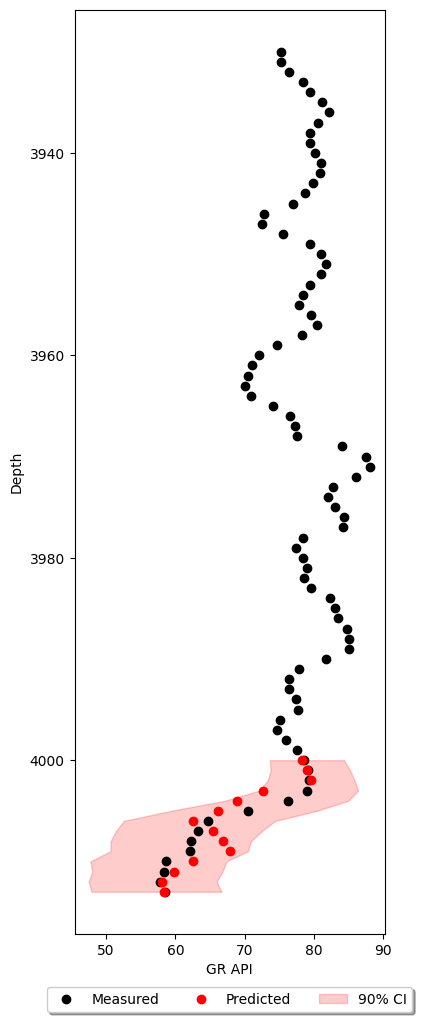

In [38]:
dec_depth_array = np.arange(depth,depth+max_prediction_length,1)
enc_depth_array = np.arange(depth-max_encoder_length,depth,1)


fig, ax  = plt.subplots(figsize=(4, 12))
ax.plot(raw_predictions['prediction'][0,:,3],dec_depth_array,'ko', label = 'Measured')
ax.plot(x['decoder_target'][0,:],dec_depth_array,'ro', label = 'Predicted')

ax.plot(x['encoder_target'][0,:],enc_depth_array,'ko')
# using raw prediction quantiles fill betweehn 2.5 and 97.5 quantile
ax.fill_betweenx(dec_depth_array, raw_predictions['prediction'][0,:,0], raw_predictions['prediction'][0,:,6], alpha=0.2, color='r', label = '90% CI')
ax.invert_yaxis()
ax.set_ylabel('Depth')
ax.set_xlabel('GR API')
# create fancy legend below the plot

ax.legend( loc='upper center', bbox_to_anchor=(0.5, -0.05),
            fancybox=True, shadow=True, ncol=5)


With attention heads


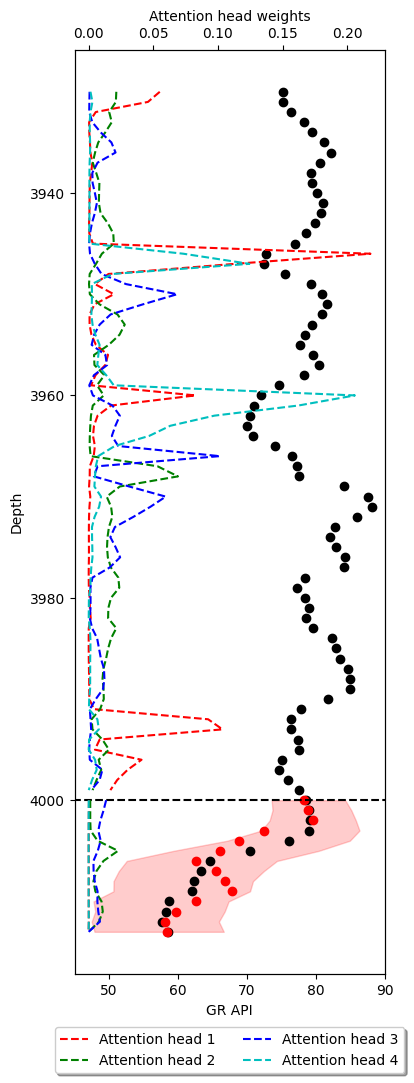

In [39]:
dec_depth_array = np.arange(depth,depth+max_prediction_length,1)
enc_depth_array = np.arange(depth-max_encoder_length,depth,1)


fig, ax  = plt.subplots(figsize=(4, 12))
ax.plot(raw_predictions['prediction'][0,:,3],dec_depth_array,'ko', label = 'Measured')
ax.plot(x['decoder_target'][0,:],dec_depth_array,'ro', label = 'Predicted')

ax.plot(x['encoder_target'][0,:],enc_depth_array,'ko')
# using raw prediction quantiles fill betweehn 2.5 and 97.5 quantile
ax.fill_betweenx(dec_depth_array, raw_predictions['prediction'][0,:,0], raw_predictions['prediction'][0,:,6], alpha=0.2, color='r', label = '90% CI')

ax.invert_yaxis()
ax.set_ylabel('Depth')
ax.set_xlabel('GR API')
# create fancy legend below the plot
ax.plot([40,100],[depth,depth],'k--')
ax.set_xlim(45,90)

ax = ax.twiny()
ax.plot(raw_predictions['encoder_attention'][0,-1,0,:],enc_depth_array,'r--',label='Attention head 1')
ax.plot(raw_predictions['encoder_attention'][0,-1,1,:],enc_depth_array,'g--',label='Attention head 2')
ax.plot(raw_predictions['encoder_attention'][0,-1,2,:],enc_depth_array,'b--',label='Attention head 3')
ax.plot(raw_predictions['encoder_attention'][0,-1,3,:],enc_depth_array,'c--',label='Attention head 4')

ax.plot(raw_predictions['decoder_attention'][0,-1,0,:],dec_depth_array,'r--')
ax.plot(raw_predictions['decoder_attention'][0,-1,1,:],dec_depth_array,'g--')
ax.plot(raw_predictions['decoder_attention'][0,-1,2,:],dec_depth_array,'b--')
ax.plot(raw_predictions['decoder_attention'][0,-1,3,:],dec_depth_array,'c--')
ax.set_xlabel('Attention head weights')
#write ylabel for twiny axis
#ax.set_xlabel('Depth')

ax.legend( loc='upper center', bbox_to_anchor=(0.5, -0.05),
            fancybox=True, shadow=True, ncol=2)


Do all the logs produce the response or is there any well log that produces the well log response

## Encoder shapley importance

In [40]:
tft.encoder_variables

['NPHI', 'SP', 'DPHI', 'GR']

In [41]:
import shap
import xgboost
from xgboost import XGBRegressor

In [42]:
Well = 0
steps = 1
length = int(180/steps)
time=850
predictions_array = np.zeros([length,14,7])
true_values = np.zeros([length,14])
importances = np.zeros([length,4])
mutual_information = np.zeros([length,4])
shap_values = np.zeros([length,4])
for i in range(0,length,steps):
    raw_prediction, x = best_tft.predict(training.filter(lambda x: (x.Well_name == 0) & (x.time_idx_first_prediction == depth)),
                                       mode="raw", return_x=True)
    predictions_array[i,:,:] = raw_prediction['prediction'][0,:,:]
    true_values[i,:]=x['decoder_target'][0,:]
    
    #time_varying_known_reals=["NPHI", "SP", "DPHI"],
    
    df=pd.DataFrame()
    df['NPHI'] =  raw_prediction["encoder_variables"][0,:,0,0]
    df['SP'] =  raw_prediction["encoder_variables"][0,:,0,1]
    df['DPHI'] =  raw_prediction["encoder_variables"][0,:,0,2]
    df['GR'] =  raw_prediction["encoder_variables"][0,:,0,3]
    df['target'] = x['encoder_target'][0,:]

    X = df.iloc[:,[0,1,2,3]]              # separate DataFrames for predictor and response features
    y = df.iloc[:,[4]]

    # xgboost for feature importance on a regression problem
    model = XGBRegressor()
    # fit the model
    model.fit(X, y)
    # get importance
    importances[i,:]=model.feature_importances_
    
#     mi = mutual_info_regression(X,np.ravel(y)) # calculate mutual information
#     mi /= np.max(mi)  
#     mutual_information[i,:]=mi
    
    explainer = shap.TreeExplainer(model)
    sp = explainer.shap_values(X)
    sp_vals = np.average(sp,axis=0)
    #sp_vals /= np.max(sp_vals)  
    shap_values[i,:] = sp_vals
    
predictions_array_new = np.zeros([predictions_array.shape[0],predictions_array.shape[0]+predictions_array.shape[1],7],)
predictions_array_new[:] = np.nan
for i in range(predictions_array.shape[0]):
     #if i<=predictions_array.shape[0]-predictions_array.shape[1]:
    predictions_array_new[i,i:(predictions_array.shape[1]+i)] = predictions_array[i,:]
predictions_array_summary = np.nanmean(predictions_array_new,0)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

In [43]:
Importance_shapley = np.abs(shap_values.sum(0))
def plot_importance_shapley(title, values, labels):
    fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))
    order = np.argsort(values)
    values = values / values.sum()
    ax.barh(np.arange(len(values)), values[order], tick_label=np.asarray(labels)[order], color = 'black',alpha = 1)
    ax.set_title(title,fontsize=15)
    ax.set_xlabel("Absolute mean SHAP value")
    plt.tight_layout()
    plt.savefig('Figure_17-Importance_of_encoder_variables.png',dpi=300)

In [44]:
X.keys()

Index(['NPHI', 'SP', 'DPHI', 'GR'], dtype='object')

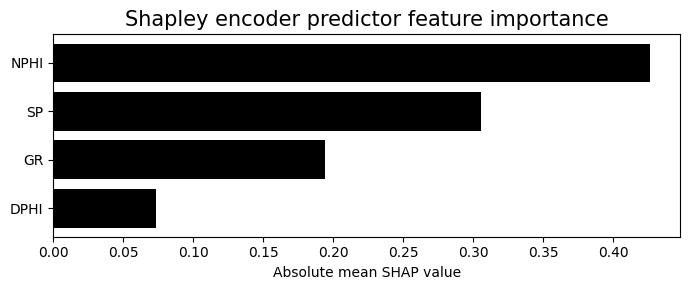

In [45]:
plot_importance_shapley('Shapley encoder predictor feature importance',
                        Importance_shapley,
                        ['NPHI', 'SP', 'DPHI','GR'])

## Shapley decoder predictor feature importance

In [46]:
tft.decoder_variables

['NPHI', 'SP', 'DPHI']

In [47]:
Well = 0
steps = 1
length = int(30/steps)
time=2000
predictions_array = np.zeros([length,14,7])
true_values = np.zeros([length,14])
importances = np.zeros([length,3])
mutual_information = np.zeros([length,3])
shap_values = np.zeros([length,3])
for i in range(0,length,steps):
    raw_prediction, x = best_tft.predict(training.filter(lambda x: (x.Well_name == 0) & (x.time_idx_first_prediction == depth)),
                                       mode="raw", return_x=True)
    #predictions.append(raw_prediction['prediction'][0,:,3])
    predictions_array[i,:,:] = raw_prediction['prediction'][0,:,:]
    true_values[i,:]=x['decoder_target'][0,:]
    
    df=pd.DataFrame()
    df['NPHI'] =  raw_prediction["decoder_variables"][0,:,0,0]
    df['SP'] =  raw_prediction["decoder_variables"][0,:,0,1]
    df['DPHI'] =  raw_prediction["decoder_variables"][0,:,0,2]
    df['target'] = raw_prediction['prediction'][0,:,-1]
    X = df.iloc[:,[0,1,2]]              # separate DataFrames for predictor and response features
    y = df.iloc[:,[3]]

    # xgboost for feature importance on a regression problem
    model = XGBRegressor()
    # fit the model
    model.fit(X, y)
    # get importance
    importances[i,:]=model.feature_importances_
    
    explainer = shap.TreeExplainer(model)
    sp = explainer.shap_values(X)
    sp_vals = np.average(sp,axis=0)
    #sp_vals /= np.max(sp_vals)  
    shap_values[i,:] = sp_vals
    
predictions_array_new = np.zeros([predictions_array.shape[0],predictions_array.shape[0]+predictions_array.shape[1],7],)
predictions_array_new[:] = np.nan
for i in range(predictions_array.shape[0]):
     #if i<=predictions_array.shape[0]-predictions_array.shape[1]:
    predictions_array_new[i,i:(predictions_array.shape[1]+i)] = predictions_array[i,:]
predictions_array_summary = np.nanmean(predictions_array_new,0)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

In [48]:
Importance_shapley = np.abs(shap_values.sum(0))
def plot_importance_shapley(title, values, labels):
    fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))
    order = np.argsort(values)
    values = values / values.sum()
    ax.barh(np.arange(len(values)), values[order], tick_label=np.asarray(labels)[order], color = 'black',alpha = 1)
    ax.set_title(title,fontsize=15)
    ax.set_xlabel("Absolute mean SHAP value")
    plt.tight_layout()
    #plt.savefig('Figure_17-Importance_of_encoder_variables.png',dpi=300)

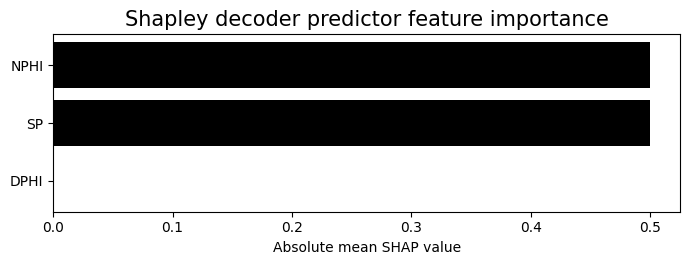

In [49]:
plot_importance_shapley('Shapley decoder predictor feature importance',
                        Importance_shapley,
                        ['NPHI', 'SP', 'DPHI'])

In [50]:
def create_mask(size, lengths, inverse: bool = False):
    """
    Create boolean masks of shape len(lenghts) x size.
    An entry at (i, j) is True if lengths[i] > j.
    Args:
        size (int): size of second dimension
        lengths (torch.LongTensor): tensor of lengths
        inverse (bool, optional): If true, boolean mask is inverted. Defaults to False.
    Returns:
        torch.BoolTensor: mask
    """

    if inverse:  # return where values are
        return torch.arange(size, device=lengths.device).unsqueeze(0) < lengths.unsqueeze(-1)
    else:  # return where no values are
        return torch.arange(size, device=lengths.device).unsqueeze(0) >= lengths.unsqueeze(-1)
    
def integer_histogram(data, min, max):
    
    uniques, counts = torch.unique(data, return_counts=True)
    if min is None:
        min = uniques.min()
    if max is None:
        max = uniques.max()
    hist = torch.zeros(max - min + 1, dtype=torch.long, device=data.device).scatter(
        dim=0, index=uniques - min, src=counts
    )
    return hist

def masked_op(tensor, op, dim, mask=None):
    if mask is None:
        mask = ~torch.isnan(tensor)
    masked = tensor.masked_fill(~mask, 0.0)
    summed = masked.sum(dim=dim)
    if op == "mean":
        return summed / mask.sum(dim=dim)  # Find the average
    elif op == "sum":
        return summed
    else:
        raise ValueError(f"unkown operation {op}")

def interpret_output(out,reduction='sum',attention_prediction_horizon = 0):
    # take attention and concatenate if a list to proper attention object
    batch_size = len(out["decoder_attention"])

    ## Decoder attention
    
    decoder_attention = out["decoder_attention"]
    print(decoder_attention.shape)
    decoder_mask = create_mask(out["decoder_attention"].size(1), out["decoder_lengths"])
    print(decoder_mask.shape)
    decoder_attention[decoder_mask[..., None, None].expand_as(decoder_attention)] = float("nan")
    print(decoder_attention.shape)
    
    ## Encoder attention
    # roll encoder attention (so start last encoder value is on the right)
    encoder_attention = out["encoder_attention"]
    shifts = encoder_attention.size(3) - out["encoder_lengths"]
    new_index = (
        torch.arange(encoder_attention.size(3), device=encoder_attention.device)[None, None, None].expand_as(
            encoder_attention
        )
        - shifts[:, None, None, None]
    ) % encoder_attention.size(3)
    encoder_attention = torch.gather(encoder_attention, dim=3, index=new_index)
    # expand encoder_attentiont to full size
    if encoder_attention.size(-1) < max_encoder_length:
        encoder_attention = torch.concat(
            [
                torch.full(
                    (
                        *encoder_attention.shape[:-1],
                        max_encoder_length - out["encoder_lengths"].max(),
                    ),
                    float("nan"),
                    dtype=encoder_attention.dtype,
                    device=encoder_attention.device,
                ),
                encoder_attention,
            ],
            dim=-1,
        )

        # combine attention vector
    attention = torch.concat([encoder_attention, decoder_attention], dim=-1)
    print(attention.shape)
    attention[attention < 1e-5] = float("nan")
    
    # histogram of decode and encode lengths
    encoder_length_histogram = integer_histogram(out["encoder_lengths"], min=0, max=max_encoder_length)
    decoder_length_histogram = integer_histogram(
        out["decoder_lengths"], min=1, max=out["decoder_variables"].size(1)
    )

    # mask where decoder and encoder where not applied when averaging variable selection weights
    encoder_variables = out["encoder_variables"].squeeze(-2)
    encode_mask = create_mask(encoder_variables.size(1), out["encoder_lengths"])
    encoder_variables = encoder_variables.masked_fill(encode_mask.unsqueeze(-1), 0.0).sum(dim=1)
    encoder_variables /= (
        out["encoder_lengths"]
        .where(out["encoder_lengths"] > 0, torch.ones_like(out["encoder_lengths"]))
        .unsqueeze(-1)
    )

    decoder_variables = out["decoder_variables"].squeeze(-2)
    decode_mask = create_mask(decoder_variables.size(1), out["decoder_lengths"])
    decoder_variables = decoder_variables.masked_fill(decode_mask.unsqueeze(-1), 0.0).sum(dim=1)
    decoder_variables /= out["decoder_lengths"].unsqueeze(-1)

    # static variables need no masking
    static_variables = out["static_variables"].squeeze(1)
    # attention is batch x time x heads x time_to_attend
    # average over heads + only keep prediction attention and attention on observed timesteps
    attention = masked_op(
        attention[
            :, attention_prediction_horizon, :, : max_encoder_length + attention_prediction_horizon
        ],
        op="mean",
        dim=1,
    )
    print(attention.shape)

    if reduction != "none":  # if to average over batches
        static_variables = static_variables.sum(dim=0)
        encoder_variables = encoder_variables.sum(dim=0)
        decoder_variables = decoder_variables.sum(dim=0)
        attention = masked_op(attention, dim=0, op=reduction)
    else:
        attention = attention / masked_op(attention, dim=1, op="sum").unsqueeze(-1)  # renormalize
    print(attention.shape)   
    interpretation = dict(
            attention=attention.masked_fill(torch.isnan(attention), 0.0),
            static_variables=static_variables,
            encoder_variables=encoder_variables,
            decoder_variables=decoder_variables,
            encoder_length_histogram=encoder_length_histogram,
            decoder_length_histogram=decoder_length_histogram,
        )
    
    return interpretation

In [51]:
def plot_interpretation(interpretation):
        figs = {}

        # attention
        fig, ax = plt.subplots()
        attention = interpretation["attention"].detach().cpu()
        attention = attention / attention.sum(-1).unsqueeze(-1)
        ax.plot(np.arange(-max_encoder_length, attention.size(0) - max_encoder_length), attention,color='black')
        ax.set_xlabel("Time index")
        ax.set_ylabel("Attention")
        ax.set_title("Attention")
        figs["attention"] = fig

        # variable selection
        def make_selection_plot(title, values, labels):
            fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))
            order = np.argsort(values)
            values = values / values.sum(-1).unsqueeze(-1)
            ax.barh(np.arange(len(values)), values[order] * 100, tick_label=np.asarray(labels)[order], color = 'black',alpha = 0.85)
            ax.set_title(title)
            ax.set_xlabel("Importance in %")
            plt.tight_layout()
            return fig

        figs["static_variables"] = make_selection_plot(
            "Static variables importance", interpretation["static_variables"].detach().cpu(), tft.static_variables
        )
        figs["encoder_variables"] = make_selection_plot(
            "Encoder variables importance", interpretation["encoder_variables"].detach().cpu(), tft.encoder_variables
        )
        figs["decoder_variables"] = make_selection_plot(
            "Decoder variables importance", interpretation["decoder_variables"].detach().cpu(), tft.decoder_variables
        )

        return figs
    
def plot_attention(interpretation):
    figs = {}
    fig, ax = plt.subplots()
    attention = interpretation["attention"].detach().cpu()
    attention = attention / attention.sum(-1).unsqueeze(-1)
    ax.plot(np.arange(-max_encoder_length, attention.size(0) - max_encoder_length), attention,color='black')
    ax.set_xlabel("Time index")
    ax.set_ylabel("Attention")
    ax.set_title("Attention")
    figs["attention"] = fig
    
    return figs

def make_selection_plot(title, values, labels):
    fig, ax = plt.subplots(figsize=(7, len(values) * 0.25 + 2))
    order = np.argsort(values)
    values = values / values.sum(-1).unsqueeze(-1)
    ax.barh(np.arange(len(values)), values[order] * 100, tick_label=np.asarray(labels)[order], color = 'black',alpha = 0.85)
    ax.set_title(title)
    ax.set_xlabel("Importance in %")
    plt.tight_layout()
    return fig

def plot_static_variable_importance(interpretation):
    figs = {}
    figs["static_variables"] = make_selection_plot(
            "Static variables importance", interpretation["static_variables"].detach().cpu(), tft.static_variables)
    return figs

def plot_encoder_variables(interpretation):
    figs = {}
    figs["encoder_variables"] = make_selection_plot(
    "Encoder variables importance", interpretation["encoder_variables"].detach().cpu(), tft.encoder_variables)
    return figs

def plot_decoder_variables(interpretation):
    figs = {}
    figs["decoder_variables"] = make_selection_plot(
        "Decoder variables importance", interpretation["decoder_variables"].detach().cpu(), tft.decoder_variables)
    return figs

In [52]:
interpretation = interpret_output(raw_predictions,reduction='sum') # Raw predictions begin at every given step.

torch.Size([1, 14, 4, 14])
torch.Size([1, 14])
torch.Size([1, 14, 4, 14])
torch.Size([1, 14, 4, 84])
torch.Size([1, 70])
torch.Size([70])


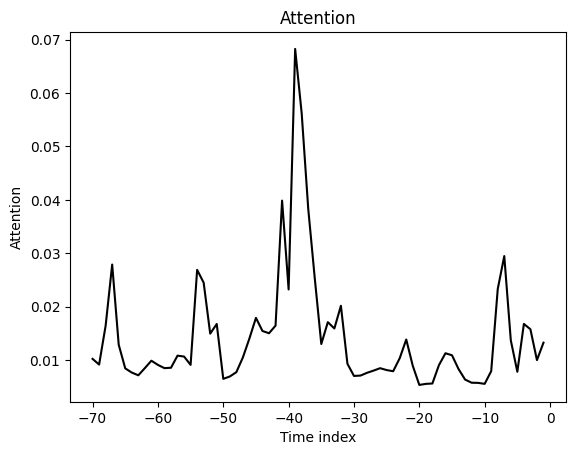

In [53]:
plot_attention(interpretation);

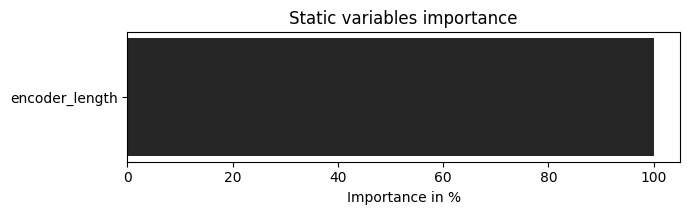

In [54]:
plot_static_variable_importance(interpretation);

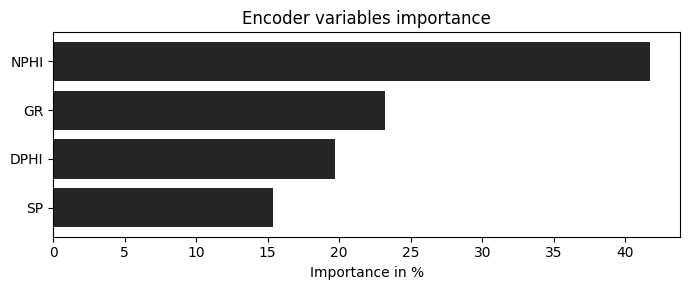

In [55]:
plot_encoder_variables(interpretation);

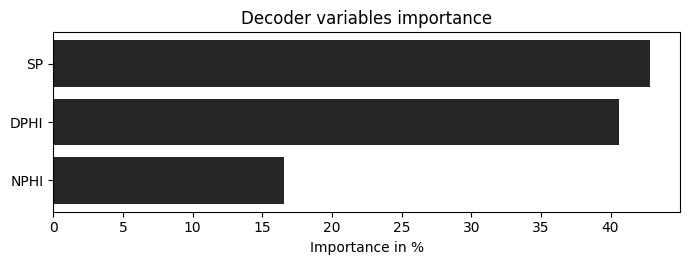

In [56]:
plot_decoder_variables(interpretation);